In [69]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


# Utilities

In [70]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
print(os.getcwd())

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

/home/oonisim/home/repositories/git/oonisim/handson-ml2/workspace


# Data

In [71]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [72]:
type(X_train_full)

numpy.ndarray

In [73]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [74]:
print(X_train.dtype)
print(X_train.shape)

float64
(55000, 28, 28)


In [75]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [76]:
class_names[y_train[0]]

'Coat'

### Callbacks

In [77]:
early_stopping_cb = keras.callbacks.EarlyStopping(
  patience=10,
  restore_best_weights=True
)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Model (SELU)

In [78]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(200, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(len(class_names), activation="softmax")
])

# First layter 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_22 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 316,810
Trainable params: 316,810
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Attach computation logic to the model
model.compile(
    loss="sparse_categorical_crossentropy",  # Cross entropy loss for sparse categorical labels
    optimizer=keras.optimizers.SGD(
        lr=0.01, momentum=0.9, nesterov=True # Use stochastic gradient descent with Nesterov momentum
    ),  
    metrics=["accuracy"]                     # Evaluate the model performance with accuracy.
)

In [80]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[
        early_stopping_cb,
        tensorboard_cb
    ]
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 28s 503us/sample - loss: 0.4878 - accuracy: 0.8221 - val_loss: 0.4781 - val_accuracy: 0.8272
Epoch 2/30
55000/55000 [==============================] - 20s 370us/sample - loss: 0.3932 - accuracy: 0.8575 - val_loss: 0.3872 - val_accuracy: 0.8618
Epoch 3/30
55000/55000 [==============================] - 21s 385us/sample - loss: 0.3583 - accuracy: 0.8681 - val_loss: 0.3305 - val_accuracy: 0.8784
Epoch 4/30
55000/55000 [==============================] - 23s 423us/sample - loss: 0.3368 - accuracy: 0.8766 - val_loss: 0.3472 - val_accuracy: 0.8726
Epoch 5/30
55000/55000 [==============================] - 37s 670us/sample - loss: 0.3254 - accuracy: 0.8792 - val_loss: 0.3586 - val_accuracy: 0.8732
Epoch 6/30
55000/55000 [==============================] - 28s 501us/sample - loss: 0.3122 - accuracy: 0.8852 - val_loss: 0.3177 - val_accuracy: 0.8854
Epoch 7/30
55000/55000 [=====================

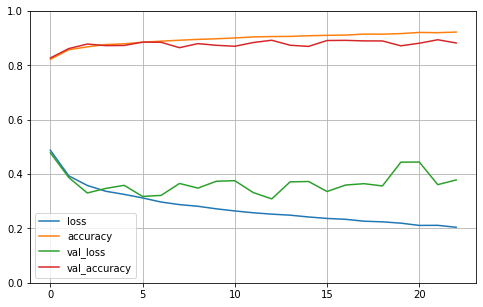

In [81]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [82]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 252us/sample - loss: 0.3559 - accuracy: 0.8799


[0.3558882947206497, 0.8799]

# Model(SELU + Momentum + Batch Normalization + Drop Out)

In [83]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),

    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(len(class_names), activation="softmax")
])

# First layter 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_14 (Batc (None, 300)               1200      
_________________________________________________________________
dense_26 (Dense)             (None, 200)               60200     
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 200)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 200)               800       
_________________________________________________________________
dense_27 (Dense)             (None, 100)              

In [84]:
# Attach computation logic to the model
model.compile(
    loss="sparse_categorical_crossentropy",  # Cross entropy loss for sparse categorical labels
    optimizer=keras.optimizers.SGD(
        lr=0.01, momentum=0.9, nesterov=True # Use stochastic gradient descent with Nesterov momentum
    ),  
    metrics=["accuracy"]                     # Evaluate the model performance with accuracy.
)

In [85]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[
        early_stopping_cb,
        tensorboard_cb
    ]
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 28s 514us/sample - loss: 0.5754 - accuracy: 0.7978 - val_loss: 0.5624 - val_accuracy: 0.8454
Epoch 2/30
55000/55000 [==============================] - 24s 433us/sample - loss: 0.4547 - accuracy: 0.8345 - val_loss: 0.5047 - val_accuracy: 0.8478
Epoch 3/30
55000/55000 [==============================] - 23s 427us/sample - loss: 0.4225 - accuracy: 0.8458 - val_loss: 0.4615 - val_accuracy: 0.8574
Epoch 4/30
55000/55000 [==============================] - 31s 568us/sample - loss: 0.3955 - accuracy: 0.8553 - val_loss: 0.4427 - val_accuracy: 0.8624
Epoch 5/30
55000/55000 [==============================] - 76s 1ms/sample - loss: 0.3751 - accuracy: 0.8629 - val_loss: 0.4070 - val_accuracy: 0.8770
Epoch 6/30
55000/55000 [==============================] - 39s 707us/sample - loss: 0.3594 - accuracy: 0.8695 - val_loss: 0.4227 - val_accuracy: 0.8740
Epoch 7/30
55000/55000 [=======================

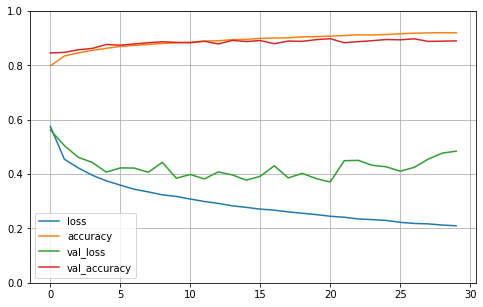

In [86]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [87]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 165us/sample - loss: 0.5843 - accuracy: 0.8796


[0.584297722479701, 0.8796]

In [88]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [89]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 56876), started 0:20:31 ago. (Use '!kill 56876' to kill it.)